                               OLS Regression Results                               
Dep. Variable:     ia_monthly_cost_per_mbps   R-squared:                       0.016
Model:                                  OLS   Adj. R-squared:                  0.015
Method:                       Least Squares   F-statistic:                     18.18
Date:                      Thu, 04 May 2017   Prob (F-statistic):           1.92e-33
Time:                              16:20:04   Log-Likelihood:                -66957.
No. Observations:                     11490   AIC:                         1.339e+05
Df Residuals:                         11479   BIC:                         1.340e+05
Df Model:                                10                                         
Covariance Type:                  nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------

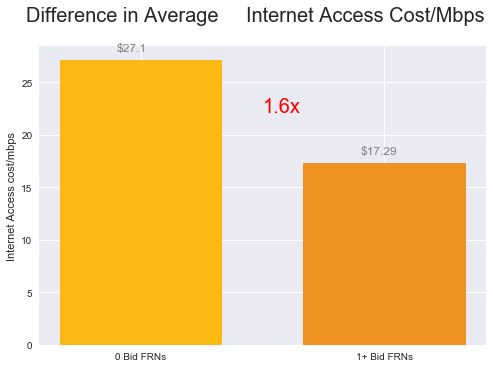

Residuals QQ-Plot


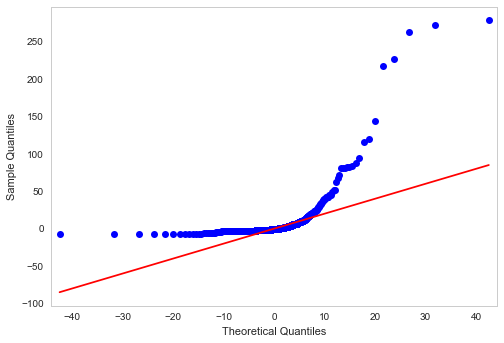

Error: Singular covariance matrix, Harvey Collier nonlinearity test not executed


In [1]:

##packages
import matplotlib.pyplot as plt
import pylab
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import seaborn
import sys
import os
sys.path.append(os.path.abspath('/Users/sierra/Documents/ESH/ficher/General_Resources/common_functions'))

## data prep
#import
districts_for_ia_cost_reg = pd.read_csv('../../data/interim/reg/districts_for_sc_reg.csv',index_col=0)
#clean for cost only for regression
districts_for_ia_cost_reg = districts_for_ia_cost_reg.loc[districts_for_ia_cost_reg['exclude_from_ia_cost_analysis'] == False]
districts_for_ia_cost_reg = districts_for_ia_cost_reg.loc[districts_for_ia_cost_reg['postal_cd'] != 'AK']
#aggregate 2+,3+
districts_for_ia_cost_reg['frns_2p_bid_ia_indicator']  = np.where(np.logical_or(districts_for_ia_cost_reg['frns_2_bid_ia_indicator'] == True, districts_for_ia_cost_reg['frns_3p_bid_ia_indicator'] == True), True, False)
#add factor for if state procures independently - https://docs.google.com/document/d/1dXYTiRystJK_SfM9pO3ZBrsOYRIUhON-nWs169Oigr8/
state_procures_independently = ['AK', 'AZ', 'CT', 'CO', 'FL', 'ID', 'IL', 'IN', 'KS', 'LA', 'MA', 'MD', 'MT', 'NH', 'NJ', 'NM', 'NV', 'OK', 'TN', 'VA', 'VT']
districts_for_ia_cost_reg['state_procures_independently'] = districts_for_ia_cost_reg['postal_cd'].isin(state_procures_independently)

## modeling prep
locale_dummies = pd.get_dummies(districts_for_ia_cost_reg.locale, prefix='locale')
#.iloc[:, 1:]
districts_for_ia_cost_reg = pd.concat([districts_for_ia_cost_reg, locale_dummies], axis=1)

type_dummies = pd.get_dummies(districts_for_ia_cost_reg.district_type, prefix='type')
#.iloc[:, 1:]
districts_for_ia_cost_reg = pd.concat([districts_for_ia_cost_reg, type_dummies], axis=1)

#add overall ia bandwidth as cost factor
feature_cols_ia_cost = ['frns_0_bid_ia_indicator', 'frns_1_bid_ia_indicator', 'frns_2p_bid_ia_indicator', 'locale_Rural', 'locale_Suburban', 'locale_Town', 'state_procures_independently', 'num_schools', 'type_Charter', 'type_BIE']

X_ia_cost = districts_for_ia_cost_reg[feature_cols_ia_cost ]
y_ia_cost = districts_for_ia_cost_reg.ia_monthly_cost_per_mbps

data_true = districts_for_ia_cost_reg.loc[districts_for_ia_cost_reg['frns_0_bid_ia_indicator'] == True]
data_true = data_true.ia_monthly_cost_per_mbps

data_false = districts_for_ia_cost_reg.loc[districts_for_ia_cost_reg['frns_0_bid_ia_indicator'] == False]
data_false = data_false.ia_monthly_cost_per_mbps

## statsmodels model
X_ia_cost = sm.add_constant(X_ia_cost)
est_ia_cost = sm.OLS(y_ia_cost, X_ia_cost.astype(float)).fit()
print(est_ia_cost.summary())

## t test
ttest_ia_cost  = scipy.stats.ttest_ind(data_true, data_false, equal_var=False)
#p-value divided by 2 for a one-tailed test (since we want to see if 0 bids are significantly GREATER THAN non-0 bids
pvalue = round(ttest_ia_cost.pvalue/2,2)
mu_true = round(np.mean(data_true),2)
mu_false = round(np.mean(data_false),2)
mu_multiple = round(np.mean(data_true)/np.mean(data_false),1)

print("Reject null hypothesis; districts that receive 0 bids on one of their internet access services have higher cost/mbps than districts with only 1+ bid internet access services. P-value: {}".format(pvalue))
print("Mean cost/mbps for districts that receive 0 bids on one of their internet access services: ${}".format(mu_true))
print("Mean cost/mbps for districts that receive 1+ bids on all of their internet access services: ${}".format(mu_false))
print("Districts that receive 0 bids on one of their internet access services pay {}x as much as districts that only receive 1 or more bids".format(mu_multiple))


y = [mu_true, mu_false]
x = [1, 2]
axis_label = ['0 Bid FRNs', '1+ Bid FRNs']
width = 1/1.5

plt.bar(x, y, width, color=["#FDB913","#F09221"], align = 'center')
plt.suptitle('Difference in Average     Internet Access Cost/Mbps', fontsize = 20)
plt.xticks(x, axis_label)
plt.ylabel('Internet Access cost/mbps')
plt.annotate("$"+str(mu_true), xy=(.9, mu_true + .9), xytext=(.9, mu_true + .9), color = "grey")
plt.annotate("$"+str(mu_false), xy=(1.9, mu_false + .9), xytext=(1.9, mu_false + .9), color = "grey")
plt.annotate(str(mu_multiple)+"x", xy=(1.5, (mu_true - mu_false)/2 + mu_false), xytext=(1.5, (mu_true - mu_false)/2 + mu_false), color = 'red', size = 20)
seaborn.despine(left=True, right=True)
seaborn.set_style("whitegrid", {'axes.grid' : False})
plt.savefig("ia_cost_by_frn_bids.png")
plt.show()

##Model diagnostics
import statsmodels_ols_diagnostics as smd
%matplotlib inline
smd.ols_model_diagnostics(est_ia_cost)

#will run only if using ipython notebook
import __main__ as main
import ipynb_convert 
ipynb_convert.executeConvertNotebook('regression_ia_cost.ipynb','regression_ia_cost_qa.py',main)